In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,8)
import scipy.stats as st


# cosmic_data.txt contains a list of mega electron volts (MeV) in the 1st column
# and the probability of the event being a solar ejecta in the 2nd column
data = np.loadtxt("cosmic_data.txt")

# a particle with an energy of 1200 MeV, we want to figure out if it's a stellar ejecta or cosmic ray
test = 1200 
print(data.shape)
print(data[:2, :])

(20000, 2)
[[1.1943876e+03 1.1170000e-01]
 [1.2317047e+03 4.5040000e-01]]


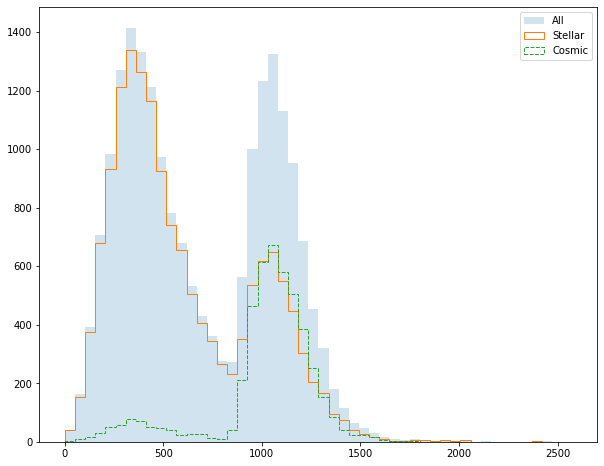

In [2]:
# 1st: visualize the data

# from data, we get the MeV of stellar ejectas and cosmic rays
# if the probability is > 50%, classify as stellar ejectas else classify as cosmic ray
stellar, cosmic = data[:,0][data[:,1] > 0.5], data[:,0][data[:,1] < 0.5]

_, bins, _ = plt.hist(data[:,0], alpha=0.2, label="All", bins=50)
plt.hist(stellar, bins=bins, histtype="step", label="Stellar")
plt.hist(cosmic, bins=bins, histtype="step", label="Cosmic", ls="--")
plt.legend();

# there's a lot of contamination, things aren't cut and dry

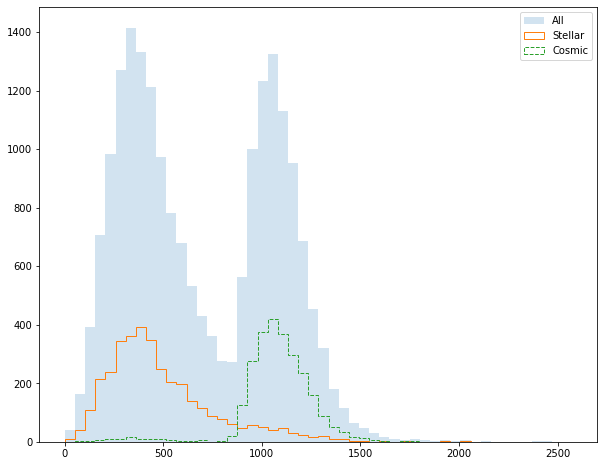

In [3]:
# with plotting, less is sometimes more. We're going to narrow our data and only plot points we're more certain of

stellar, cosmic = data[:,0][data[:,1] > 0.9], data[:,0][data[:,1] < 0.1]

_, bins, _ = plt.hist(data[:,0], alpha=0.2, label="All", bins=50)
plt.hist(stellar, bins=bins, histtype="step", label="Stellar")
plt.hist(cosmic, bins=bins, histtype="step", label="Cosmic", ls="--")
plt.legend();

# after filtering further, it looks like we no longer see that bi-modal structure like in the figure above
# there are only single peaks for both cosmic rays and stellar ejectas

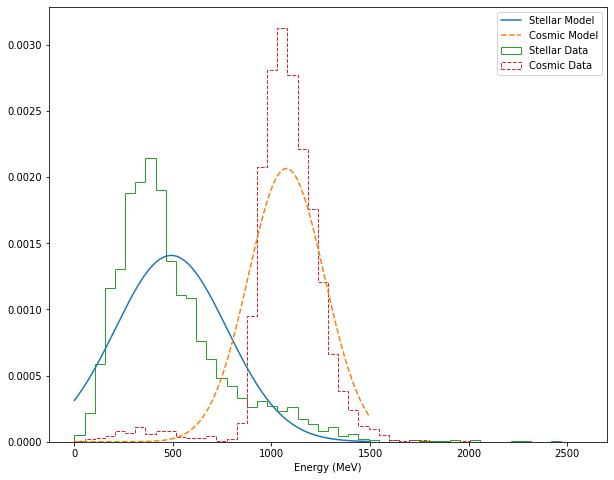

In [4]:
# 2nd data fitting

params_s = st.norm.fit(stellar)
params_c = st.norm.fit(cosmic)

# plot
xs = np.linspace(0, 1500, 200)
stellar_probs = st.norm.pdf(xs, *params_s)
cosmic_probs = st.norm.pdf(xs, *params_c,)
plt.plot(xs, stellar_probs, label="Stellar Model")
plt.plot(xs, cosmic_probs, label="Cosmic Model", ls="--")
plt.hist(stellar, bins=bins, histtype="step", density=True, label="Stellar Data")
plt.hist(cosmic, bins=bins, histtype="step", density=True, label="Cosmic Data", ls="--")
plt.legend()
plt.xlabel("Energy (MeV)");

# the graphs look terrible, using a normal distribution to approximate our data won't cut it 😑

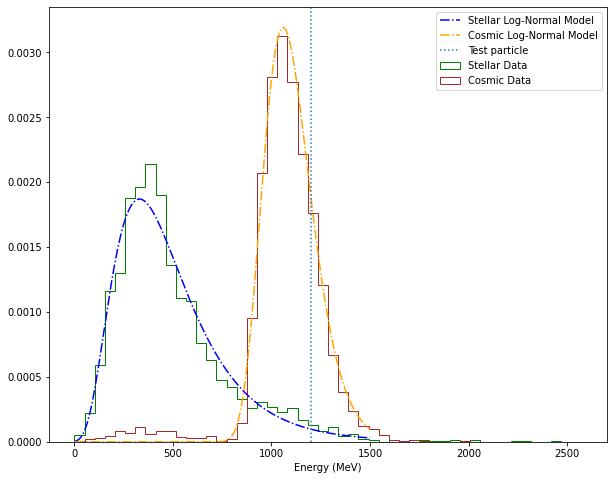

In [5]:
# I'm going to try a skewnorm and log-normal too see if one of those models provides a better approximation

params_s_skew = st.skewnorm.fit(stellar)
stell_skew_pdf = st.skewnorm.pdf(xs, *params_s_skew)

params_c_skew = st.skewnorm.fit(cosmic)
cos_skew_pdf = st.skewnorm.pdf(xs, *params_c_skew)

# get rid of contaminated data by setting a threshold
cosmic2 = cosmic[cosmic > 700]

params_s_log = st.lognorm.fit(stellar, loc=1200, scale=100)
stell_lognorm_pdf = st.lognorm.pdf(xs, *params_s_log)

params_c_log = st.lognorm.fit(cosmic2, loc=400, scale=100)
cos_lognorm_pdf = st.lognorm.pdf(xs, *params_c_log)

# Skew Normals
# plt.plot(xs, stell_skew_pdf, label="Stellar Skew-Normal Model", ls="--", color="orange")
# plt.plot(xs, cos_skew_pdf, label="Cosmic Skew-Normal Model", ls="--", color="red")

# Log Normals
plt.plot(xs, stell_lognorm_pdf, label="Stellar Log-Normal Model", ls="-.", color="blue")
plt.plot(xs, cos_lognorm_pdf, label="Cosmic Log-Normal Model", ls="-.", color="orange")

plt.hist(stellar, bins=bins, histtype="step", density=True, label="Stellar Data", color="green")
plt.hist(cosmic, bins=bins, histtype="step", density=True, label="Cosmic Data", color="brown")
plt.axvline(test, ls=":", label="Test particle")
plt.legend()
plt.xlabel("Energy (MeV)");

# the log-normals provided a better fit

# based solely on the visualization, it looks likes our test particle would be a cosmic ray
# but we need to normalize our results

In [6]:
# normalizing to find the probability of our test particle being a cosmic ray

n_stellar, n_cosmic = stellar.shape[0], cosmic.shape[0]

prob_cosmic = st.lognorm.pdf(test, *params_c_log) * n_cosmic
prob_stellar = st.lognorm.pdf(test, *params_s_log) * n_stellar
total_prob = prob_cosmic + prob_stellar
final = prob_cosmic/total_prob
print(f"The final probability of this event being a cosmic ray is {final*100:.1f}%")


The final probability of this event being a cosmic ray is 93.4%
